# Oddball Assessment

In [1]:
from __future__ import annotations

from collections.abc import Iterator
import json
import itertools
from pprint import pprint
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, HDBSCAN, DBSCAN    # pyright: ignore [reportAttributeAccessIssue]  HDBSCAN not recognized.
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

from umap import UMAP

if TYPE_CHECKING:
    from sklearn.base import BaseEstimator

/home/philosofool/repos/philosofool/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = 'archive/CC GENERAL.csv'
# see https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?resource=download for dataset description.
df = pd.read_csv(data_path)

## Data Exploration and Discussion

The data is very clean. Missing values are only in CREDIT_LIMIT and MINIMUM_PAYMENT, 1 and ~300 (of 8950) respectively. 
These are easy to explain: a no-limit card and card-holders with no payment history to date.
There are some huge outliers.
The the variables are not normally distributed; they tend to center to the left and right in histograms. 
A few have a bathtub shape.

CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user


In [3]:
print('Missing Value Counts')
pprint({key: value for key, value in df.isna().sum().items() if value > 0})
print("Duplicate Record Count")
print(len(df) - len(df.drop_duplicates()))

Missing Value Counts
{'CREDIT_LIMIT': 1, 'MINIMUM_PAYMENTS': 313}
Duplicate Record Count
0


In [4]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Evaluation Process

Per my preference, I define evaluation before modeling. This is because:
- It's a bad idea to create a model you don't know how to evaluate. It can result in deciding a model has virtues you can find rather than virtues you expect.
- It's a good idea to have conversation about how a model will be assess before you can talk about the strengths and weakness of a model. (Teams take responsibility for what counts as good, expressing requirements, etc.)
- Is intelletually honest about the quality of evaluation you can produce. 
(Clustering, for example, does not have an obvious right answer, but depends on application.)
- It encourages writing flexible evalution functions, which makes model development and iteration faster in the long run. (Promotes code re-use.)


In [6]:
def simple_logs(new_data: dict | list | str, path: str):
    """Append new data to an existing json, or create one if it does not exist."""
    try:
        with open(path, 'r') as f:
            data = json.loads(f.read())
    except FileNotFoundError:
        data = []
    data.append(new_data)
    with open(path, 'w') as f:
        f.write(json.dumps(data, indent=4))

def evaluate_unsupervised_clustering(model: BaseEstimator, data: np.ndarray) -> dict:
    """
    Evaluate an unsupervised clustering model using common clustering metrics.

    Parameters
    ----------
    model : BaseEstimator
        A fitted or unfitted scikit-learn compatible clustering model (e.g., KMeans, HDBSCAN).
        The model must implement a `.fit_predict` method.

    data : np.ndarray
        The input data array of shape (n_samples, n_features) to cluster.

    Returns
    -------
    scores : dict
        A dictionary containing the following metrics:
        - 'n_labels': int
            The number of non-noise clusters found (ignores label -1).
        - 'noise_percent': float
            Proportion of data points labeled as noise (-1).
        - 'silhouette_score': float
            Silhouette score of the clustering (0 if fewer than 2 clusters).
        - 'calinski_harabasz_score': float
            Calinski-Harabasz index of the clustering (0 if fewer than 2 clusters).

    Notes
    -----
    If the model finds fewer than 2 clusters (excluding noise), the silhouette and
    Calinski-Harabasz scores will be set to 0, as these metrics are undefined in that case.
    """
    scores = {}
    clustered_data = model.fit_predict(data)
    labels = np.unique(clustered_data)
    value_counts = pd.Series(clustered_data).value_counts()
    if value_counts.get(-1):
        del value_counts[-1]
    scores['n_labels'] = labels.size - (-1 in labels)
    scores['noise_percent'] = np.sum((clustered_data == -1)) / clustered_data.size
    if not value_counts.empty:
        scores['largest_cluster_size'] = int(value_counts.max())
        scores['smallest_cluster_size'] = int(value_counts.min())
    else:
        # possible 100% noise.
        scores['largest_cluster_size'] = 0
        scores['smallest_cluster_size'] = 0
    if scores['n_labels'] > 1:
        scores['silhouette_score'] = silhouette_score(data, clustered_data, metric='euclidean')
        scores['calinski_harabasz_score'] = calinski_harabasz_score(data, clustered_data)
    else:
        scores['silhouette_score'] = 0
        scores['calinski_harabasz_score'] = 0
    return scores


def test_evaluate_unsupervised_clustering():
    from sklearn.cluster import KMeans

    model = KMeans(n_clusters=3, random_state=123)
    data, *_ = make_blobs(random_state=567)

    result = evaluate_unsupervised_clustering(model, data)
    assert result['silhouette_score'] > 0
    assert result['calinski_harabasz_score'] > 0
    assert result['noise_percent'] >= 0 and result['noise_percent'] <= 1.
    assert result['n_labels'] == 3


test_evaluate_unsupervised_clustering()

## Clustering Model

In [7]:
def clean_data(df: pd.DataFrame, selected_columns: list[str] = []) -> np.ndarray:
    if selected_columns:
        df = df[selected_columns]
    else:
        df = df.drop(columns=['CUST_ID'])
    data = ColumnTransformer(
        [step for step in [
            ('min_payment', SimpleImputer(strategy='constant', fill_value=-1.), ['MINIMUM_PAYMENTS']),
            ('credit_limit', SimpleImputer(strategy='constant', fill_value=200_000.), ['CREDIT_LIMIT']),
        ]
        if step[2][0] in selected_columns or not selected_columns],
        remainder='passthrough'
    ).fit_transform(df)
    return data

def fit_and_evaluate_model(model: BaseEstimator, data_transform: Pipeline, df: pd.DataFrame = df):
    data = clean_data(df)
    transformed_data = data_transform.fit_transform(data)
    return evaluate_unsupervised_clustering(model, transformed_data)

def param_grid_to_parameters(param_grid: dict[str, list]) -> Iterator:
    parameters = list(param_grid)
    for param_options in itertools.product(*param_grid.values()):
        param_spec = {parameters[i]: param_value for i, param_value in enumerate(param_options)}
        yield param_spec

def tune(model_name: str, pipeline: Pipeline, df: pd.DataFrame, param_grid: dict):
    """Extract parameters from a parameters grid and trained the re-parameterized model on the data in df."""
    parameter_grid = param_grid[model_name]
    for parameters in param_grid_to_parameters(parameter_grid):
        pipeline.set_params(**parameters)
        data_transform = pipeline.named_steps['data_transform']
        cluster_model = pipeline.named_steps['clustering']
        scores = fit_and_evaluate_model(cluster_model, data_transform, df)
        scores['model_name'] = model_name
        results = {'parameters': parameters, 'scores': scores}
        simple_logs(results, 'model_scores.json')


In [8]:
# Define Data Preprocessing and Model Architecture
# This will be passed through a tuning process, so we can mostly use default values now.

data_transform_standard_pca = Pipeline([
    ('scale_data', StandardScaler()),
    ('PCA', PCA(n_components=4)),
])
data_transform_umap = Pipeline([
    ('scale_data', StandardScaler()),
    ('UMAP', UMAP(n_components=30)),
])
data_transform_robust_pca = Pipeline([
    ('scale_data', RobustScaler()),
    ('PCA', PCA(n_components=3)),
])

clustering_models: dict[str, Pipeline] = {
    'kmeans_model': Pipeline([
        ('data_transform', data_transform_standard_pca),
        ('clustering', KMeans(n_clusters=4))
    ]),
    'normalize_kmeans': Pipeline([
        ('data_transform', data_transform_standard_pca),
        ('clustering', KMeans(n_clusters=4))
    ]),
    'hdb_model': Pipeline([
        ('data_transform', data_transform_standard_pca),
        ('clustering', HDBSCAN())
    ]),
    'robust_hdb_model': Pipeline([
        ('data_transform', data_transform_robust_pca),
        ('clustering', HDBSCAN(min_cluster_size=50))
    ]),
    'umap_hdb_model': Pipeline([
        ('data_transform', data_transform_umap),
        ('clustering', HDBSCAN(min_cluster_size=50))
    ]),
    'db_model': Pipeline([
        ('data_transform', data_transform_standard_pca),
        ('clustering', DBSCAN())
    ]),
}

In [9]:
# Define Hyperparameters

hdb_param_grid = {
    'data_transform__PCA__n_components': [2, 3, 4],
    'clustering__min_cluster_size': [100, 500],
    'clustering__min_samples': [None, 3, 7, 20],
}
kmeans_param_grid = {
    'data_transform__PCA__n_components': [2, 3, 4, 5, .95],
    'clustering__n_clusters': [2, 3, 4, 5]
}
umap_param_grid = {
    # 'data_transform__UMAP__n_neighbors': [3, 5, 10, 30],
    'data_transform__UMAP__n_neighbors': [40, 50, 75],
    'data_transform__UMAP__n_components': [2],
    'clustering__min_cluster_size': [100, 500],
    'clustering__min_samples': [None, 3, 7, 20],
}
db_param_grid = {
    'data_transform__PCA__n_components': [2, 3, 4],
    'clustering__eps': [.3, .5, .75, 1.],
    # 'clustering__min_samples': [None, 3, 7, 20],
}

clustering_models_params = {
    'kmeans_model': kmeans_param_grid,
    'normalize_kmeans': kmeans_param_grid,
    'hdb_model': hdb_param_grid,
    'robust_hdb_model': hdb_param_grid,
    'umap_hdb_model': umap_param_grid,
    'db_model': db_param_grid
}


In [ ]:
for model_name, pipeline in clustering_models.items():
    ...
    # UNCOMMENT TO RUN. Takes a ~5 minutes.
    # tune(model_name, pipeline, df, clustering_models_params)


In [14]:
def quality_models() -> list[dict]:
    """
    Load and filter clustering model results based on quality criteria.

    This function reads model evaluation results from a JSON file (`model_scores.json`)
    and returns a list of models that meet specific quality thresholds. These thresholds
    are used to filter out low-quality or poorly performing clustering models.

    The filtering criteria are:
    - The number of clusters (`n_labels`) is between 2 and 7 (inclusive).
    - The proportion of noise points (`noise_percent`) is less than or equal to 0.25.
    - The silhouette score is at least 0.3.

    Returns
    -------
    list of dict
        A list of model evaluation dictionaries that pass the quality filter.
        Each dictionary contains a 'scores' field and other metadata.

    Notes
    -----
    The input file `model_scores.json` must exist in the current working directory
    and must contain a JSON array of model evaluation results, each with a 'scores'
    dictionary containing the keys:
    - 'n_labels'
    - 'noise_percent'
    - 'silhouette_score'
    """
    with open("model_scores.json", 'r') as f:
        tuning_data = json.loads(f.read())

    def is_acceptable(score_data: dict) -> bool:
        score = score_data['scores']
        return (
            score['n_labels'] >= 2
            and score['largest_cluster_size'] < 7000
            and score['n_labels'] <= 7
            and score['noise_percent'] <= .25
            and score['silhouette_score'] >= .3
        )
    return [score_data for score_data in tuning_data if is_acceptable(score_data)]


In [15]:
# Extract results to a dataframe. List best models with more than 2 labels.
acceptable_models = quality_models()
scores = pd.DataFrame.from_records([a['scores'] | a['parameters'] for a in acceptable_models])
scores.sort_values('silhouette_score', ascending=False).query("n_labels > 2").head()

,n_labels,noise_percent,largest_cluster_size,smallest_cluster_size,silhouette_score,calinski_harabasz_score,model_name,data_transform__PCA__n_components,clustering__n_clusters
1,3,0.0,6073,1205,0.449372,5314.614587,kmeans_model,2,3
14,3,0.0,6059,1214,0.448912,5314.578994,normalize_kmeans,2,3
2,4,0.0,3907,505,0.408735,5808.215901,kmeans_model,2,4
15,4,0.0,3939,485,0.408537,5807.596146,normalize_kmeans,2,4
16,5,0.0,3643,39,0.406778,6008.175143,normalize_kmeans,2,5


In [16]:
scores.sort_values('silhouette_score', ascending=False).query("n_labels == 2").head()

,n_labels,noise_percent,largest_cluster_size,smallest_cluster_size,silhouette_score,calinski_harabasz_score,model_name,data_transform__PCA__n_components,clustering__n_clusters
13,2,0.0,5400,3550,0.373935,4044.760946,normalize_kmeans,2,2
0,2,0.0,5399,3551,0.373929,4044.738180,kmeans_model,2,2
4,2,0.0,5348,3602,0.343801,3458.478003,kmeans_model,3,2
17,2,0.0,5334,3616,0.343555,3458.771134,normalize_kmeans,3,2
21,2,0.0,5280,3670,0.307672,2962.542561,normalize_kmeans,4,2


## Assessment

Our decision criteria were:
- producing large enough groups to be potentially useful.
- producing few enough groups to be potentially useful.
- the silhouette score of the model. (calinski_harabasz_score is well correlated.)
- low noise (for relevant models.)

### KMeans

DBSCAN and HDBSCAN approaches produced no useful models. 
Either the clusters were too large, the noise too high, or the score too low.

KMeans models with 3 labels performed best. Two (Models 1 and 14), based on 2 principle components, scored .45 silhouette.
Both had a single very large group, around 6050 members and a modest small group, around 1200 members.
KMeans classifies all samples (no noise.)
Selection between these is arbitrary.

One 4 label model, model 2, is also of interest. It has a lower score, .41, but it's largest group is 3907 members,
suggesting an interesting additional partition.


### Process Assessment

We tuned a large range of hyperparameters to find the above models.
It is noteworthy that seemingly adjacent models in the parameter space sometimes diverged in scores.
These models fit to this data quickly and there is little concern that more exploration would be too computationally expensive.
Along these lines, investigation of DBSCAN and other clustering models is also recommended. 


## Cluster Characterisitcs

In [ ]:
def extract_model(scores, index):
    model_spec = scores.loc[index]
    model_name = model_spec['model_name']
    parameters = list(clustering_models_params[model_name])
    param_values = model_spec[parameters]
    for key, value in param_values.items():
        if key == 'data_transform__PCA__n_components':
            if value < 1:
                # we're using a quantile to select the number of PCA components.
                param_values[key] = value
                continue
            param_values[key] = int(value)
        elif np.isnan(value):
            # this indicates we should use the default, but `nan` won't be accepted as the default value.
            param_values[key] = None
            # del(param_values[key])
            # continue
        else:
            param_values[key] = int(value)
    print(param_values)
    model = clustering_models[model_name]
    model.set_params(**param_values.to_dict())
    return model


def scatter_features(ax, x_feature, y_feature, df):
    x = df[x_feature]
    y = df[y_feature]
    ax.scatter(x, y, col)

def cluster_characteristics(model, df):
    """Visualize Cluster Characteristics."""
    df = df.copy()
    df['cluster'] = model.named_steps['clustering'].labels_

    selected_features = ['BALANCE_FREQUENCY', 'PAYMENTS', 'CREDIT_LIMIT', 'PURCHASES', 'BALANCE']
    assert all(feature in df for feature in selected_features), "You probably have a typo."

    feature_combinations = list(itertools.combinations(selected_features, 2))
    n_cols = 3
    n_rows = (len(feature_combinations)) // n_cols + (1 if len(feature_combinations) % n_cols else 0)
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(3 * n_rows, 3 * n_cols)
    for i, (x_feature, y_feature) in enumerate(feature_combinations):
        row = i // n_cols
        col = i % n_cols
        current_ax = ax[row][col]
        x = df[x_feature]
        y = df[y_feature]
        current_ax.scatter(x, y, c=df['cluster'], alpha=.5)
        current_ax.set_xlabel(x_feature)
        current_ax.set_ylabel(y_feature)
    fig.tight_layout()


data_transform__PCA__n_components    2
clustering__n_clusters               3
Name: 14, dtype: object
2    5964
1    1811
0    1175
Name: count, dtype: int64


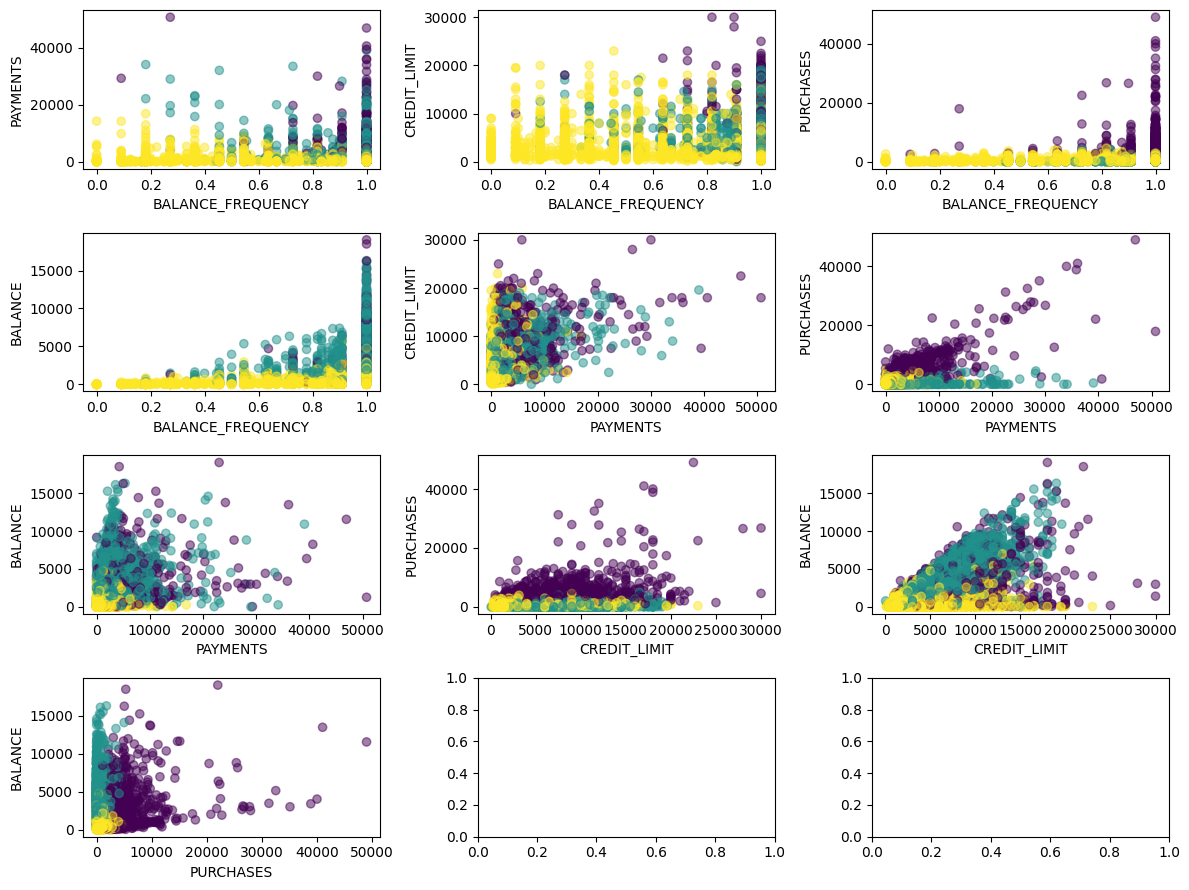

In [42]:
model_14 = extract_model(scores, 14)
model_14.fit(clean_data(df))
print(pd.Series(model_14.named_steps['clustering'].labels_).value_counts())
cluster_characteristics(model_14, df)

data_transform__PCA__n_components    2
clustering__n_clusters               4
Name: 2, dtype: object
0    3913
2    3311
3    1221
1     505
Name: count, dtype: int64


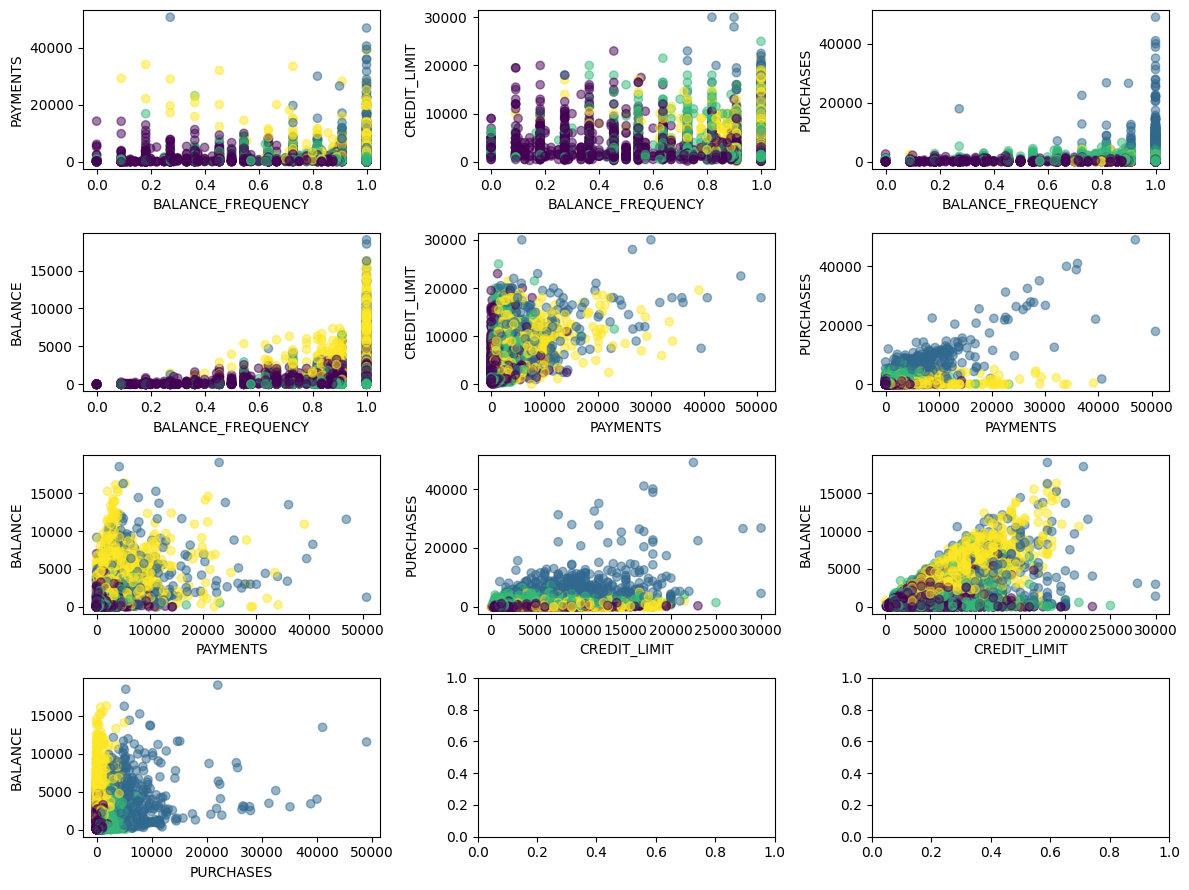

In [43]:
model_2 = extract_model(scores, 2)
model_2.fit(clean_data(df))
print(pd.Series(model_2.named_steps['clustering'].labels_).value_counts())
cluster_characteristics(model_2, df)